# OSACT 6 Task 2: Translating Arabic Dialects to Modern Standard Arabic

Among the challenges involved with using Arabic in large language models is the disparity of dialects used throughout the Arab world. While modern Standard Arabic is used prolifically in official and government use-cases, among the general public, it is seldom ever used. Instead, various **vernaculars** are used, local to various regions across the Middle East and North Africa. These vernaculars can be divided into subgroups, the count of which can vary from the single digits to dozens, depending on the level of granularity through which one defines the geographic differences.


<br>
<center> <img src = "./Arabic_Dialects.svg.png" width=60%> 

<p style="font-size: 9px; width: 60%" >
Schmitt, Genevieve A. (2019). "Relevance of Arabic Dialects: A Brief Discussion". In Brunn, Stanley D.; Kehrein, Roland (eds.). Handbook of the Changing World Language Map. Springer. p. 1385. doi:10.1007/978-3-030-02438-3_79. ISBN 978-3-030-02437-6. as "Fig. 1 Major dialects of Arabic, by region. (Open source)".
</p>
</center>

<br>

The dataset provided by OSACT-6 aggregates the dialects into the following five language subgroups:
    
- Egyptian
- Iraqi
- Levantine
- Maghrebi
- Gulf

The dataset contains 200 sentences from each dialect, with its corresponding translation in MSA. As such, the baseline naive model accuracy the machine learning model should be expected to beat is 0.2.

*Note: On the 14 of February, the competition updated to include revisions of the Gulf arabic sentences.*
## EDA

### Counts and Lengths
First, we load the dataset and show some sample data.

In [1]:
import pandas as pd

dataset = pd.read_json("./dev_set_all.json")
dataset = dataset.set_index("id")

dataset.sample(5)

/var/folders/vn/mvm19hjd09x1mql689t6qhmh0000gn/T/ipykernel_56704/2888386001.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,dialect,source,target
id,,,
420147,Levantine,وأنا الحر اللي يبي الصيد,وأنا الحر الذي يرغب في الصيد
422612,Magharebi,ومزال اتشوف اكتر من هك,ولا تزال تشاهد أكثر من ذلك
420199,Levantine,اخاف الجماعة يجون باشر ياما عقب باشر,أخاف أن تأتي الجماعة غداً أو بعد غد
418630,Egyptian,عشان عارف كويس أوي ان أنت مش بتحب دموعي,لأنني أعلم جيدًا أنك لا تحب دموعي
422475,Magharebi,مع هاذ العباد هذاك واش لازم,هذا ما يلزم مع مثل هؤلاء


In [2]:
dataset.groupby("dialect").sum()[["source"]]

dataset["source_char_length"] = dataset["source"].str.len()
dataset["source_word_length"] = dataset["source"].str.split().str.len()
dataset["target_char_length"] = dataset["target"].str.len()
dataset["target_word_length"] = dataset["target"].str.split().str.len()

dataset.sample(5)

,dialect,source,target,source_char_length,source_word_length,target_char_length,target_word_length
id,,,,,,,
422210,Magharebi,هذا ما يمنعش انو الانسان يخلي معاملات المالية ...,هذا لا يمنع الإنسان من إجراء المعاملات المالية...,81,15,82,15
50007,Gulf,كل واحد على حسب,كل شخص وفقًا لـ,15,4,15,4
420150,Levantine,بلشت إسماع هن عم بيحكوا عن حادث صار بنفس الشارع,بدأت أسمع هناك يتحدثون عن حادث حدث في نفس الشارع,47,10,48,10
422269,Magharebi,والله لو كان غير يهديهم ربي ويفهموا روحهم، إن ...,والله لو يهديهم الله ويفهموا أنفسهم، إن شاء ال...,74,15,74,14
422278,Magharebi,يا ربي .. كريم ما شاء الله .. وفيك الخير,يا الله .. كريم ما شاء الله .. وفيك الخير,40,10,41,10


In [3]:
dataset.groupby("dialect").sum().describe()

,source_char_length,source_word_length,target_char_length,target_word_length
count,5.000000,5.000000,5.000000,5.000000
mean,8391.600000,1684.400000,8974.000000,1713.800000
std,1355.846341,254.138348,1496.063668,260.168599
min,6198.000000,1284.000000,6475.000000,1290.000000
25%,8001.000000,1598.000000,8733.000000,1644.000000
50%,8988.000000,1795.000000,9666.000000,1839.000000
75%,9216.000000,1811.000000,9806.000000,1861.000000
max,9555.000000,1934.000000,10190.000000,1935.000000


array([[<Axes: title={'center': 'source_char_length'}>,
        <Axes: title={'center': 'source_word_length'}>],
       [<Axes: title={'center': 'target_char_length'}>,
        <Axes: title={'center': 'target_word_length'}>]], dtype=object)

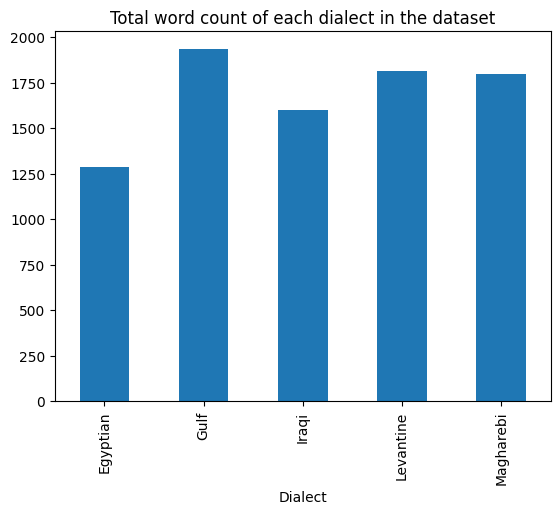

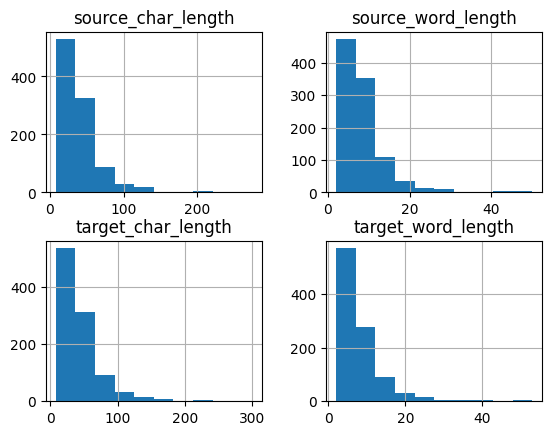

In [4]:
import matplotlib.pyplot as plt

dataset.groupby("dialect").sum()[["source_word_length"]].plot(kind="bar", xlabel="Dialect", ylabel="", legend="", title="Total word count of each dialect in the dataset")

dataset.hist()

In [36]:

dataset[["dialect", "source_word_length"]].groupby("dialect").sum()


,source_word_length
dialect,
Egyptian,1284
Gulf,1934
Iraqi,1598
Levantine,1811
Magharebi,1795


As word counts are completely unrelated to the type of dialect, this data may bias the model, creating an association between length and dialect.

### Term Frequency Analysis

We can get a better understanding of how the model should perform by examining the differences between dialects and MSA. Each MSA target is unique, suggesting that each source-target pair is unique in meaning. This complicates the analysis, but it should be doable given the appropriate approach. To begin, we can explore each of the regional dialects.

#### Unigram Analysis

We observe the corpuses both with and without stopwords, to compare and better understand the differences in regional dialects. We first begin with a unigram analysis, using wordclouds. The code below constructs two sets of wordclouds. Each set contains six wordclouds, one for each of the five dialects, and MSA. One set contains the stopwords, the other does not.

In [19]:
import wordcloud as wc
from arabic_reshaper import arabic_reshaper
from bidi.algorithm import get_display
from nltk.corpus import stopwords

# This is going to run terribly but it'll do for now
def generate_wordcloud(text, width = 1000, height = 1000):
    render_ready_text = get_display(arabic_reshaper.reshape(text))
    return wc.WordCloud(
        font_path = "./Janna-LT-Bold.ttf",
        background_color = "white",
        #colormap="Blues",
        width = width,
        height = height,
    ).generate(render_ready_text)


clouds_without_stopwords = []
clouds_with_stopwords = []

for dialect in dataset.dialect.unique():
    raw_text = dataset[dataset["dialect"] == dialect]["source"].sum()

    filtered_text = " ".join([w for w in raw_text.split() if w not in stopwords.words("arabic")])
    render_ready_filtered_text = get_display(arabic_reshaper.reshape(filtered_text)) 
   
    clouds_without_stopwords.append(generate_wordcloud(raw_text))
    clouds_with_stopwords.append(generate_wordcloud(filtered_text))

#Adding the MSA WordClouds
msa_text = dataset["target"].sample(200).sum()
filtered_msa_text = " ".join([w for w in msa_text.split() if w not in stopwords.words("arabic")])

clouds_without_stopwords.append(generate_wordcloud(filtered_msa_text))
clouds_with_stopwords.append(generate_wordcloud(msa_text))

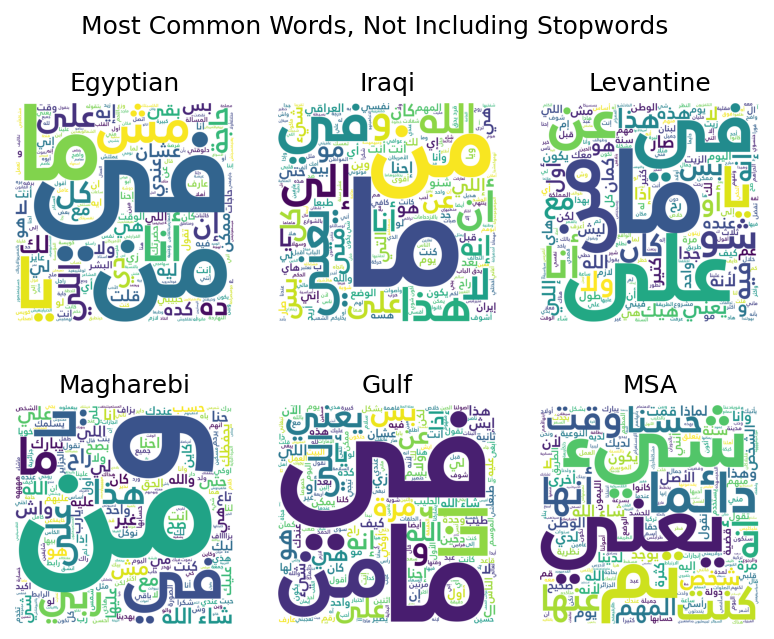

In [20]:
fig, axes = plt.subplots(2, 3)

fig.set_dpi(150)

fig.suptitle("Most Common Words, Not Including Stopwords")

axes[0, 0].set_title("Egyptian")
axes[0, 0].axis("off")
axes[0, 0].imshow(clouds_without_stopwords[0])

axes[0, 1].set_title("Iraqi")
axes[0, 1].axis("off")
axes[0, 1].imshow(clouds_without_stopwords[1])

axes[0, 2].set_title("Levantine")
axes[0, 2].axis("off")
axes[0, 2].imshow(clouds_without_stopwords[2])

axes[1, 0].set_title("Magharebi")
axes[1, 0].axis("off")
axes[1, 0].imshow(clouds_without_stopwords[3])

axes[1, 1].set_title("Gulf")
axes[1, 1].axis("off")
axes[1, 1].imshow(clouds_without_stopwords[4])

axes[1, 2].set_title("MSA")
axes[1, 2].axis("off")
axes[1, 2].imshow(clouds_without_stopwords[5])

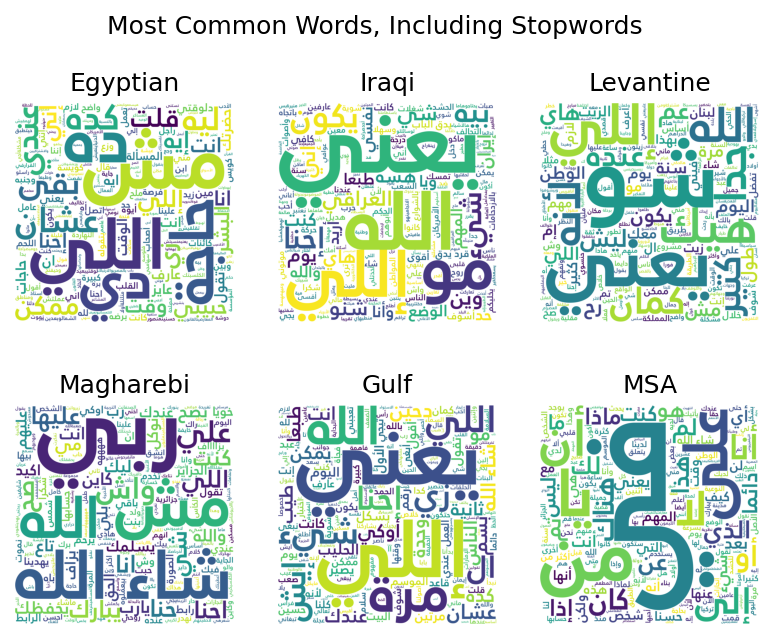

In [21]:
fig, axes = plt.subplots(2, 3)

fig.set_dpi(150)

fig.suptitle("Most Common Words, Including Stopwords")

axes[0, 0].set_title("Egyptian")
axes[0, 0].axis("off")
axes[0, 0].imshow(clouds_with_stopwords[0])

axes[0, 1].set_title("Iraqi")
axes[0, 1].axis("off")
axes[0, 1].imshow(clouds_with_stopwords[1])

axes[0, 2].set_title("Levantine")
axes[0, 2].axis("off")
axes[0, 2].imshow(clouds_with_stopwords[2])

axes[1, 0].set_title("Magharebi")
axes[1, 0].axis("off")
axes[1, 0].imshow(clouds_with_stopwords[3])

axes[1, 1].set_title("Gulf")
axes[1, 1].axis("off")
axes[1, 1].imshow(clouds_with_stopwords[4])

axes[1, 2].set_title("MSA")
axes[1, 2].axis("off")
axes[1, 2].imshow(clouds_with_stopwords[5])

From a preliminary glance, it appears that the stopwords provide enough variance to the dataset that it would be best to include them- they provide big hints as to what dialect the sentence comes from. Still, we will attempt to generate text using both corpuses as training data to see which provides the most accurate translations. We also note similarities between Iraqi and Levantine arabic, which tracks with the linguistic theories of arabic - Iraqi Arabic is also commonly referred to as South Levantine Arabic.

#### Bi-gram Analysis

/Users/abinladin/research/osact-6/.venv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آمين', 'أب', 'أخ', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إم', 'ات', 'اتان', 'ارتد', 'ان', 'انفك', 'برح', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'سيما', 'صه', 'ظل', 'ظن', 'عد', 'قط', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هب', 'واها', 'وراء'] not in stop_words.
  warnings.warn(


<BarContainer object of 25 artists>

/Users/abinladin/research/osact-6/.venv/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from current font.
  func(*args, **kwargs)
/Users/abinladin/research/osact-6/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


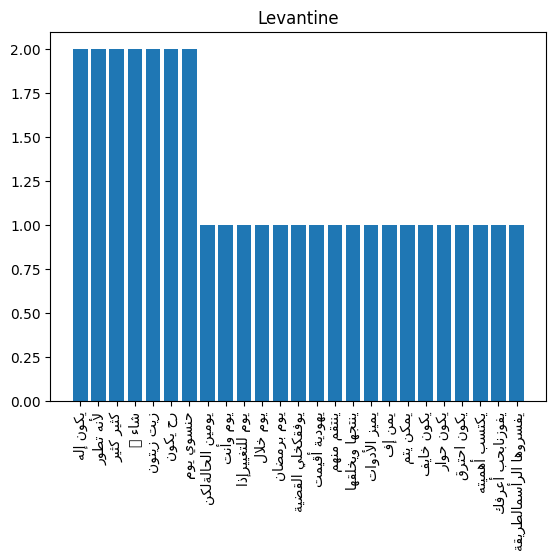

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

dialect = "Levantine"

vec = CountVectorizer(stop_words=stopwords.words("arabic"), ngram_range=(2,2))
bow = vec.fit_transform(dataset.groupby("dialect").sum().loc[dialect][["source"]])
count_values = bow.toarray().sum(axis=0)

ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in vec.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

ngram_freq = ngram_freq.head(25)

plt.title(dialect)
plt.xticks(rotation=90)
plt.bar(ngram_freq["ngram"].apply(lambda x: get_display(arabic_reshaper.reshape(x))), ngram_freq["frequency"])

### LDA and PCA Analysis

To better understand the distinction and crossover between dialects

## Translation

There are two main approaches I'm considering:

- Training the entire dataset on a single model
- Using LDA analysis to classify the sentence to a dialect, then run it through a model trained specifically on said dialect - perhaps an MoE as a more sophisticated method?

In [9]:
import logging, time
